<a href="https://colab.research.google.com/github/Hafizusmanjaved/Final-year-project-Usman1/blob/main/HEART_EDA_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Automated Diagnosis of Coronary Heart Disease Using Machine Learning Classification**

# **Part 1: Importing Files and Loading Dataset**

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score, classification_report, accuracy_score

# URLs for all four datasets
data_urls = {
    "Cleveland": "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
    "Hungary": "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data",
    "Switzerland": "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data",
    "Long Beach VA": "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data"
}

columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']

# Load and combine
df_list = []
for region, url in data_urls.items():
    temp_df = pd.read_csv(url, names=columns, na_values='?')
    temp_df['region'] = region  # Track origin for EDA
    df_list.append(temp_df)

df_combined = pd.concat(df_list, ignore_index=True)
print(f"Combined Dataset: {df_combined.shape[0]} rows from 4 regions.")

Combined Dataset: 920 rows from 4 regions.


# **Part II: Exploratory Data Analysis**

## **Checking Missing Values**

Missing values per feature:
age           0
sex           0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalach      55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
region        0
dtype: int64


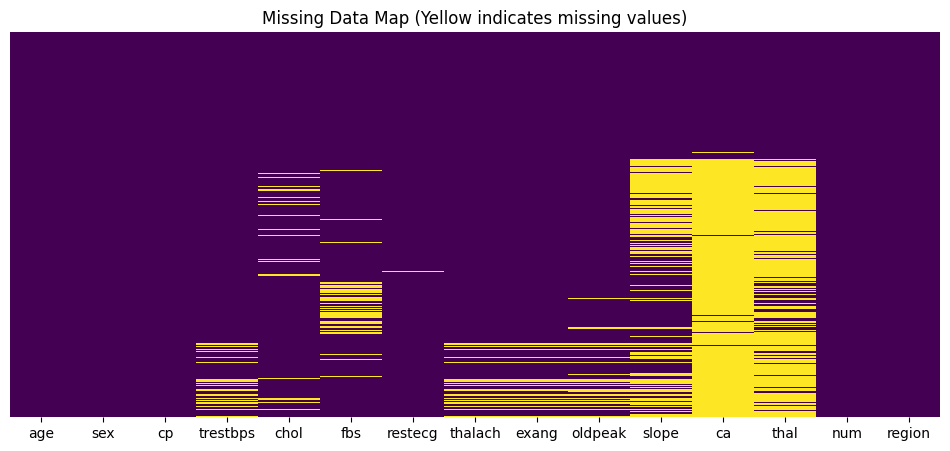

In [32]:
# Convert '?' to NaN so Pandas can recognize them as missing
df_combined = df_combined.replace('?', np.nan)

# Check the count of missing values per column
print("Missing values per feature:")
print(df_combined.isnull().sum())

# Visualize the 'sparsity' of the data
plt.figure(figsize=(12, 5))
sns.heatmap(df_combined.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title("Missing Data Map (Yellow indicates missing values)")
plt.show()

## **Filling Missing Values using Interpolation**

In [33]:
import pandas as pd
import numpy as np

# 1. Convert '?' to NaN and ensure all features are numeric
# We exclude 'region' if you added it earlier, as it is a string
cols_to_convert = [c for c in df_combined.columns if c != 'region']
df_combined[cols_to_convert] = df_combined[cols_to_convert].apply(pd.to_numeric, errors='coerce')

# 2. Define column types for specific imputation strategies
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
continuous_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']

# 3. Perform Imputation
# Fill categorical columns with the Mode (most frequent value)
for col in categorical_cols:
    if col in df_combined.columns:
        df_combined[col] = df_combined[col].fillna(df_combined[col].mode()[0])

# Fill continuous columns with the Median (robust to outliers)
for col in continuous_cols:
    if col in df_combined.columns:
        df_combined[col] = df_combined[col].fillna(df_combined[col].median())

# 4. Final Re-check
print("--- Missing Values After Imputation ---")
missing_counts = df_combined.isnull().sum()
print(missing_counts)

if missing_counts.sum() == 0:
    print("\nSuccess: No missing values remaining.")
else:
    print(f"\nWarning: {missing_counts.sum()} missing values still present.")

--- Missing Values After Imputation ---
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
region      0
dtype: int64

Success: No missing values remaining.


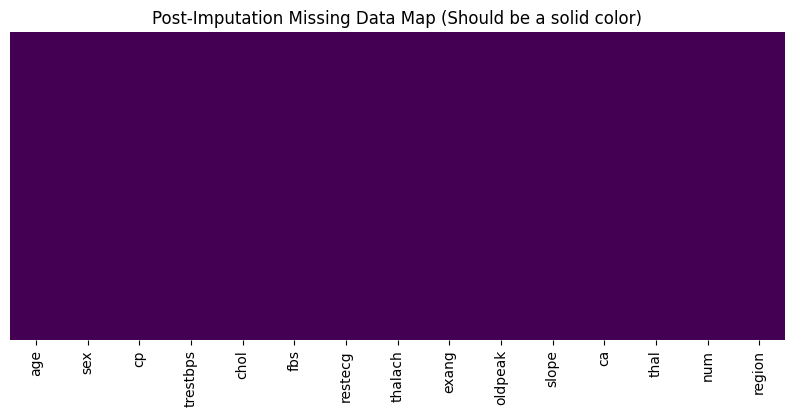

In [34]:
plt.figure(figsize=(10, 4))
sns.heatmap(df_combined.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title("Post-Imputation Missing Data Map (Should be a solid color)")
plt.show()

## **Coorelation Heatmap**

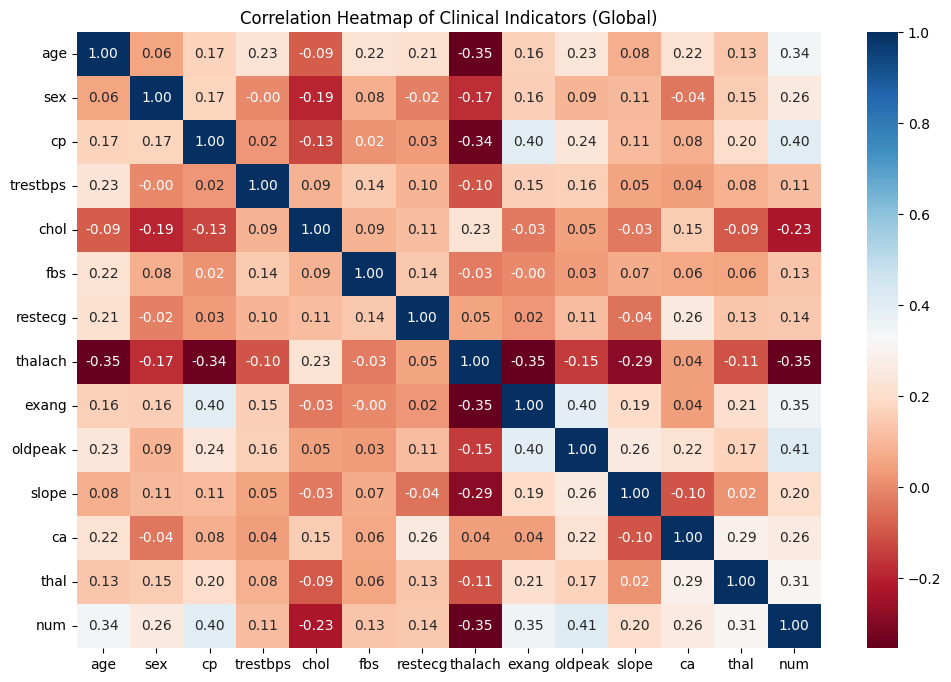

In [35]:
plt.figure(figsize=(12, 8))
correlation_matrix = df_combined.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', fmt='.2f')
plt.title("Correlation Heatmap of Clinical Indicators (Global)")
plt.show()

## **Distribution Graph**

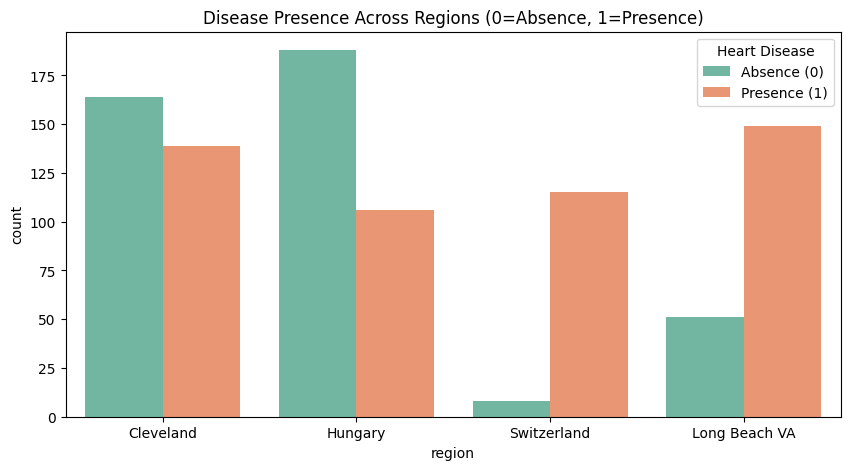

In [36]:
#Visualize Heart Disease Presence by Region
# We use 'num' > 0 to define disease presence
df_combined['has_disease'] = (df_combined['num'] > 0).astype(int)

plt.figure(figsize=(10, 5))
sns.countplot(data=df_combined, x='region', hue='has_disease', palette='Set2')
plt.title("Disease Presence Across Regions (0=Absence, 1=Presence)")
plt.legend(title='Heart Disease', labels=['Absence (0)', 'Presence (1)'])
plt.show()

/tmp/ipython-input-3729379011.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='num', data=df_combined, palette='magma')


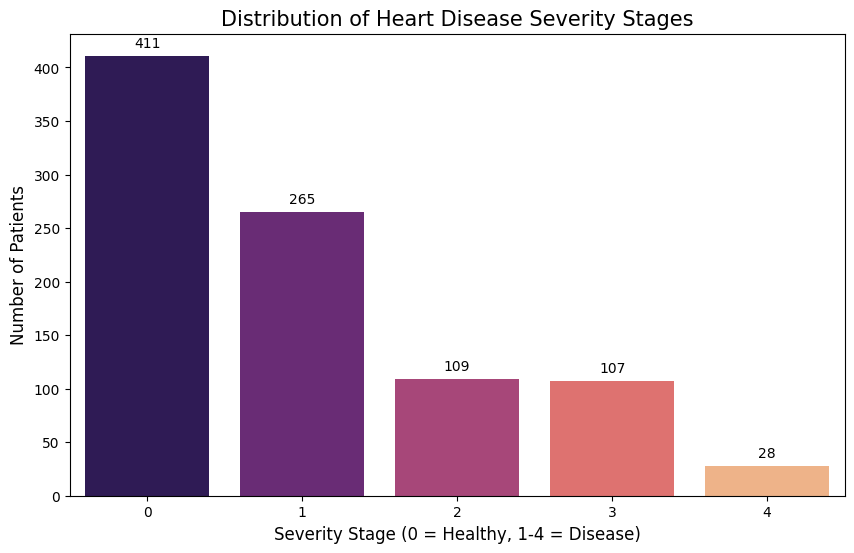

In [37]:
plt.figure(figsize=(10, 6))
# Create the countplot for the 5 stages
ax = sns.countplot(x='num', data=df_combined, palette='magma')

# Add labels and title
plt.title('Distribution of Heart Disease Severity Stages', fontsize=15)
plt.xlabel('Severity Stage (0 = Healthy, 1-4 = Disease)', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)

# Add value labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')

plt.show()

In [38]:
df_combined.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,region,has_disease
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,Cleveland,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,Cleveland,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,Cleveland,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,Cleveland,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,Cleveland,0


# **Preprocessing Data**

In [39]:
import pandas as pd

# Define the columns that need encoding
# Note: sex, fbs, and exang are already binary (0/1),
# so they are typically left as-is, but can be added here if preferred.
categorical_cols = ['cp', 'restecg', 'slope', 'ca', 'thal', 'region']

# Apply One-Hot Encoding
# drop_first=True is used to avoid multicollinearity (the dummy variable trap)
# by removing one redundant column for each category.
df_encoded = pd.get_dummies(df_combined, columns=categorical_cols, drop_first=False)

# Verify the changes
print(f"Original shape: {df_combined.shape}")
print(f"Encoded shape: {df_encoded.shape}")
print(df_encoded.head())

Original shape: (920, 16)
Encoded shape: (920, 31)
    age  sex  trestbps   chol  fbs  thalach  exang  oldpeak  num  has_disease  \
0  63.0  1.0     145.0  233.0  1.0    150.0    0.0      2.3    0            0   
1  67.0  1.0     160.0  286.0  0.0    108.0    1.0      1.5    2            1   
2  67.0  1.0     120.0  229.0  0.0    129.0    1.0      2.6    1            1   
3  37.0  1.0     130.0  250.0  0.0    187.0    0.0      3.5    0            0   
4  41.0  0.0     130.0  204.0  0.0    172.0    0.0      1.4    0            0   

   ...  ca_1.0  ca_2.0  ca_3.0  thal_3.0  thal_6.0  thal_7.0  \
0  ...   False   False   False     False      True     False   
1  ...   False   False    True      True     False     False   
2  ...   False    True   False     False     False      True   
3  ...   False   False   False      True     False     False   
4  ...   False   False   False      True     False     False   

   region_Cleveland  region_Hungary  region_Long Beach VA  region_Switzerland

## **Splitting Train and Test Data**

In [40]:
from sklearn.model_selection import train_test_split

# 1. Separate features and target
# We drop 'num' because it is the target.
# We also drop 'has_disease' to prevent data leakage.
X = df_encoded.drop(columns=['num', 'has_disease'])
y = df_encoded['num']

# 2. Split the data
# test_size=0.2 means 20% of the data goes to the test set
# random_state ensures reproducibility
# stratify=y ensures the distribution of disease stages is similar in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Verify the results
print(f"Total samples: {len(df_encoded)}")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")

Total samples: 920
Training samples: 736
Testing samples: 184
Number of features: 29
